In [82]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import seaborn as sns
from scipy.stats.mstats import winsorize
%matplotlib inline

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from useducation',con=engine)

engine.dispose()
print(df.head())

       PRIMARY_KEY       STATE  YEAR  ENROLL  TOTAL_REVENUE  FEDERAL_REVENUE  \
0     1992_ALABAMA     ALABAMA  1992     NaN      2678885.0         304177.0   
1      1992_ALASKA      ALASKA  1992     NaN      1049591.0         106780.0   
2     1992_ARIZONA     ARIZONA  1992     NaN      3258079.0         297888.0   
3    1992_ARKANSAS    ARKANSAS  1992     NaN      1711959.0         178571.0   
4  1992_CALIFORNIA  CALIFORNIA  1992     NaN     26260025.0        2072470.0   

   STATE_REVENUE  LOCAL_REVENUE  TOTAL_EXPENDITURE  INSTRUCTION_EXPENDITURE  \
0      1659028.0       715680.0          2653798.0                1481703.0   
1       720711.0       222100.0           972488.0                 498362.0   
2      1369815.0      1590376.0          3401580.0                1435908.0   
3       958785.0       574603.0          1743022.0                 964323.0   
4     16546514.0      7641041.0         27138832.0               14358922.0   

   ...  GRADES_4_G  GRADES_8_G  GRADES_12_G 

In [83]:
columns = list(df.columns)
remove = {'PRIMARY_KEY', 'STATE', 'YEAR', 'AVG_READING_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_MATH_4_SCORE'}
columns = [e for e in columns if e not in remove]

states = df['STATE'].unique()


for state in states:
    df.loc[df['STATE'] == state, columns] = df.loc[df['STATE'] == state, columns].interpolate()


# Since we interpolated the missing continuous variables, I'm assuming this drops the remaining missing categorical?
df.dropna(inplace=True)

Both fields have outliers


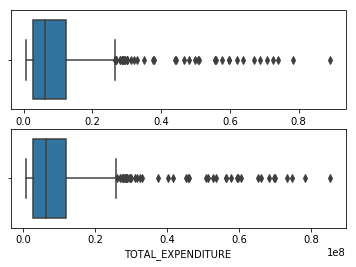

In [84]:
# 1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?
f, axes = plt.subplots(2, 1)
sns.boxplot(x = df['TOTAL_REVENUE'], ax = axes[0])
sns.boxplot(x = df['TOTAL_EXPENDITURE'], ax = axes[1])
print('Both fields have outliers')

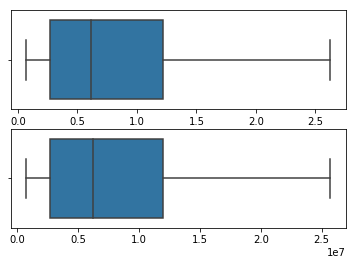

In [85]:
# 2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this 
# checkpoint to eliminate them and validate that there's no outlier values afterwards you handled them

df_wr = winsorize(df['TOTAL_REVENUE'], (0, .1))
df_we = winsorize(df['TOTAL_EXPENDITURE'], (0, .1))

f, axes = plt.subplots(2, 1)
sns.boxplot(x = df_wr, ax = axes[0], whis = 10)
sns.boxplot(x = df_we, ax = axes[1], whis = 10)


There are outliers


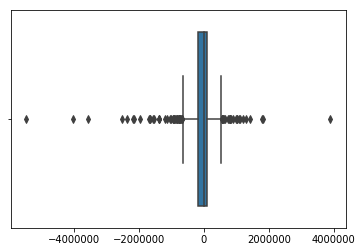

In [93]:
# 3. Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? 
# If so, eliminate them using the technique you think most suitable.

deficit = df['TOTAL_REVENUE'] - df['TOTAL_EXPENDITURE']
sns.boxplot(x = deficit)
print('There are outliers')

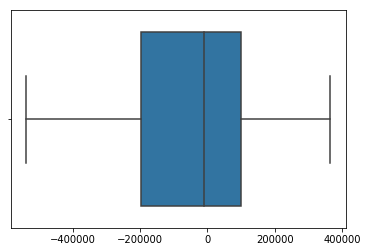

In [87]:
def_w = winsorize(deficit, (0.1, 0.1))
sns.boxplot(x = def_w, whis = 10)

There are outliers


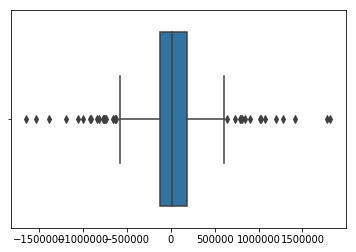

In [94]:
# 4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE.
# In this newly created variable, can you find any outliers? If so, eliminate them.

deficit2 = df_wr - df_we
sns.boxplot(x = deficit2)
print('There are outliers')

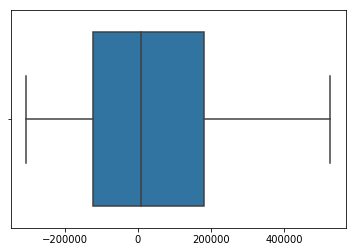

In [96]:
def_w2 = winsorize(deficit2, (0.1, 0.1))
sns.boxplot(x = def_w2, whis = 10)

In [119]:
# 5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions.
# Do you see any differences?


# Can't figure out how to name columns, I like the sample solution a lot more
# pd.concat([pd.DataFrame(deficit), pd.DataFrame(def_w), pd.DataFrame(def_w2)], axis = 1).describe()

pd.DataFrame({'Original_Budget' : deficit, 'Winsorized_Budget1' : def_w, 'Winsorized_Budget2' : def_w2}).describe()


,Original_Budget,Winsorized_Budget1,Winsorized_Budget2
count,4.660000e+02,466.000000,466.000000
mean,-8.094882e+04,-46221.075107,58068.461373
std,6.144222e+05,256023.510074,261701.775745
min,-5.487742e+06,-538253.000000,-306362.000000
25%,-1.965748e+05,-196574.750000,-123882.250000
50%,-8.872500e+03,-8872.500000,8133.500000
75%,1.013948e+05,101394.750000,180287.250000
max,3.897129e+06,365079.000000,526078.000000


The measures of central tendency differ a good deal between the two winsorized variants of the budget deficit

6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

Taking the difference of the budget and expenditure might remove some outliers, you it's probably a good diea to try that first.

